In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import cv2
import imageio
import base64
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
from fastai.data.external import untar_data, URLs
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from google.colab import files


In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
!cp /content/drive/MyDrive/AEECS442/Final_Project/imgs.zip imgs.zip
!cp /content/drive/MyDrive/AEECS442/Final_Project/img_classes.zip img_classes.zip

In [ ]:
!unzip imgs.zip
!unzip img_classes.zip

In [6]:
# Source: https://stackoverflow.com/questions/13405956/convert-an-image-rgb-lab-with-python
from PIL import ImageCms
srgb_profile = ImageCms.createProfile("sRGB")
lab_profile  = ImageCms.createProfile("LAB")
rgb2lab_transform = ImageCms.buildTransformFromOpenProfiles(srgb_profile, lab_profile, "RGB", "LAB")
lab2rgb_transform = ImageCms.buildTransformFromOpenProfiles(lab_profile, srgb_profile, "LAB", "RGB")

def rgb2lab(img):
  return ImageCms.applyTransform(img, rgb2lab_transform)

def lab2rgb(img):
  return ImageCms.applyTransform(img, lab2rgb_transform)

In [ ]:
# Source: https://colab.research.google.com/github/mberkay0/image-colorization/blob/main/ImageColorization.ipynb#scrollTo=xE-uUStuv1Nl
seed = 123
fit = False
SIZE = 256
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names

In [ ]:
### GETTING IMAGE SUBSET ###
idx = 0
counter = 0
testarr = []
while counter < 10000:
  path = paths[idx]
  idx += 1
  # Get image name
  name = path.split("/")[-1]
  name = name.split(".")[0]

  # Make sure image can be opened (some can't, idk why)
  try:
    img = Image.open(path).convert('LAB').resize((256, 256), resample=Image.BICUBIC)
  except:
    print("Failed to open: ", name)
    continue

  # Get image A and B channels
  img_arr = np.array(img).astype(int)

  img_A = img_arr[:,:,1]
  img_B = img_arr[:,:,2]

  # Get A-B class
  img_A_class = img_A // 16
  img_B_class = img_B // 16
  img_class = (img_A_class*16) + img_B_class

  # Save image class
  out_path_class = f"img_classes/{name}.png"
  cv2.imwrite(out_path_class, img_class)

  # Save greyscale image too
  out_path_img = f"imgs/{name}.png"
  cv2.imwrite(out_path_img, img_arr[:,:,0])

  counter += 1
  testarr.append(1)
  if (counter % 100) == 0:
    print((counter // 100), "%")

print("Final len:", len(testarr))

1 %
2 %
3 %
Failed to open:  000000134918
4 %
5 %
6 %
7 %
8 %
Failed to open:  000000518951
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
Failed to open:  000000150354
37 %
38 %
Failed to open:  000000313608
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
Failed to open:  000000093120
49 %
Failed to open:  000000560349
50 %
51 %
52 %
53 %
54 %
55 %
Failed to open:  000000426558
56 %
57 %
58 %
59 %
60 %
61 %
62 %
Failed to open:  000000578250
63 %
64 %
65 %
66 %
67 %
Failed to open:  000000518025
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %
Final len: 10000


In [ ]:
# Save images and image class data for reuse, if necessary
!zip -r /content/imgs.zip /content/imgs
!zip -r /content/img_classes.zip /content/img_classes

!cp imgs.zip /content/drive/MyDrive/AEECS442/Final_Project/
!cp img_classes.zip /content/drive/MyDrive/AEECS442/Final_Project/

In [7]:
# Now for model training -- getting indices first
seed = 123
fit = False
SIZE = 256
np.random.seed(seed)

In [8]:
# Randomly partition train and validation images
# np.random is seeded so the partition is always the same, in case of program crashes
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set

In [9]:
# Now getting image paths
img_names = np.array([os.path.basename(path) for path in glob.glob("content/imgs/*.png")])
train_names = img_names[train_idxs]
val_names = img_names[val_idxs]

000000254277.png
000000421298.png
000000502508.png
000000254277.png
000000421298.png
000000502508.png


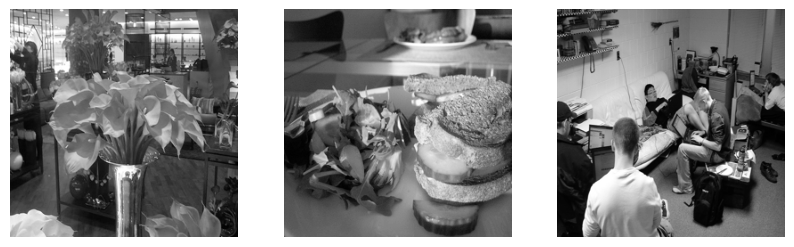

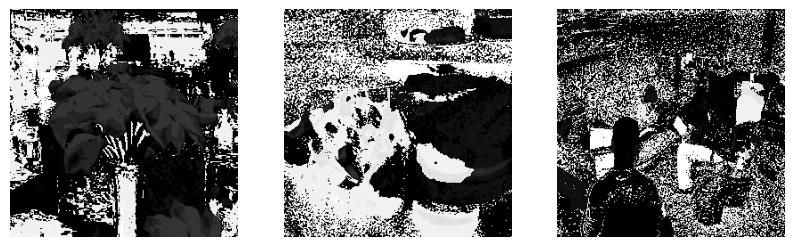

In [10]:
# Making sure paths are working
_, axes = plt.subplots(1, 3, figsize=(10, 10))
for ax, img_name in zip(axes.flatten(), train_names):
    ax.imshow(Image.open(f"content/imgs/{img_name}"), cmap='gray')
    print(img_name)
    ax.axis("off")

# These images are meant to look odd -- they're color class indices
# Some object-wise consistency is expected -- something may be wrong if there is none
_, axes = plt.subplots(1, 3, figsize=(10, 10))
for ax, img_name in zip(axes.flatten(), train_names):
    ax.imshow(Image.open(f"content/img_classes/{img_name}"), cmap='gray')
    print(img_name)
    ax.axis("off")

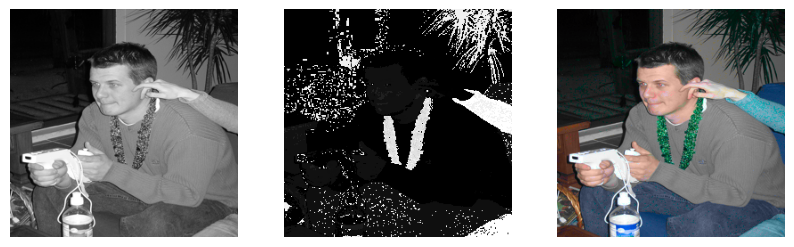

In [11]:
# Visualizing the reconstruction from the image class files
def visualize_classification(img_name):
  img_path = f"content/imgs/{img_name}"
  img_class_path = f"content/img_classes/{img_name}"

  # Get image A and B channels
  img_class = np.array(Image.open(img_class_path)).astype(int)
  img_A = (img_class // 16) * 16
  img_B = (img_class % 16) * 16

  # Get image L channel from original image
  img_L = np.array(Image.open(img_path)).astype(int)

  # Reconstruct image in RGB
  img_recon = np.stack([img_L, img_A, img_B], axis=2).astype("uint8")
  img_recon_rgb = np.array(lab2rgb(Image.fromarray(img_recon, mode="LAB")))

  # Outputting original image and reconstruction
  img = np.array(Image.open(img_path)).astype(int)
  return img, img_class, img_recon_rgb

# Print an example
img, img_class, img_recon_rgb = visualize_classification(img_names[0])
_, axes = plt.subplots(1, 3, figsize=(10, 10))
for ax, image in zip(axes.flatten(), [img, img_class, img_recon_rgb]):
    ax.imshow(image, cmap='gray')
    ax.axis("off")

# Left image is the greyscale source
# Middle image is the class indices
# Right image is the ground truth colorized image, reconstructed from the left two

In [ ]:
# Getting the number of pixels in the entire dataset that belong to each class
class_counts = np.zeros(256)
count = 0
for name in img_names:
  img_class_path = f"img_classes/{name}"
  img_class = np.array(Image.open(img_class_path)).astype(int).flatten()
  for i in img_class:
    class_counts[i] += 1
  count += 1
  if (count % 100) == 0:
    print(count // 100, "%")

print(class_counts)

1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %
[2.25309778e+08 6.60461800e+07 1.61596910e+07 3.38825700e+06
 7.65227000e+05 9.12420000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.00000000e+00 7.43040000e+04
 7.34787000e+05 2.43472300e+06 8.46472700e+06 6.80703210e+07
 1.30946400e+07 2.61171780e+07 1.57822450e+07 4.22245700e+06
 7.80413000e+05 2.06180000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.30970000e+04 1.52327000e+05
 4.18560000e+05 5.54677000e+05 8.25437000e+05 2.52050600e+06
 1.60577700e+06 5.06

In [12]:
# Run this cell instead of the one above if you have the class counts file
class_counts = np.load("class_counts.npy")

In [13]:
# Sanity check
print(np.sum(class_counts))
print(class_counts)

655360000.0
[2.25309778e+08 6.60461800e+07 1.61596910e+07 3.38825700e+06
 7.65227000e+05 9.12420000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.00000000e+00 7.43040000e+04
 7.34787000e+05 2.43472300e+06 8.46472700e+06 6.80703210e+07
 1.30946400e+07 2.61171780e+07 1.57822450e+07 4.22245700e+06
 7.80413000e+05 2.06180000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.30970000e+04 1.52327000e+05
 4.18560000e+05 5.54677000e+05 8.25437000e+05 2.52050600e+06
 1.60577700e+06 5.06553000e+06 5.45543300e+06 2.37866900e+06
 3.88548000e+05 1.10000000e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.93000000e+02 2.94400000e+04 8.35660000e+04
 6.20250000e+04 6.66100000e+04 2.20556000e+05 4.63051000e+05
 4.16010000e+05 1.19775100e+06 2.11885900e+06 1.06300500e+06
 1.44811000e+05 2.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.67600000e+03 1.29780000e+04 8.15800000e+03
 9.72300000e+03 2.56170000e+04 6.10780000e+04 2.29444000e+05
 8.51880000e

In [14]:
np.save("class_counts.npy", class_counts)
# Getting class weights from their counts (described in report)
# Multiplying by 10000 is for numerical stability; this doesn't affect the model
class_counts_corrected = ((class_counts + 100000)**(-1/2)) * 10000
print(class_counts_corrected)
np.save("class_counts_corrected.npy", class_counts_corrected)

# This reshape will be useful for weighting with losses
class_weight_tensor = torch.from_numpy(class_counts_corrected)
class_weight_tensor = torch.unsqueeze(class_weight_tensor, -1)
class_weight_tensor = torch.unsqueeze(class_weight_tensor, -1)
class_weight_tensor = torch.unsqueeze(class_weight_tensor, 0).to(device)

[ 0.66606042  1.22955402  2.47995532  5.35421446 10.75065607 22.86695629
 31.6227766  31.6227766  31.6227766  31.6227766  31.62214417 23.9522504
 10.94490916  6.28108611  3.4169863   1.21116226  2.75296841  1.95302152
  2.5092507   4.80988463 10.65753522 28.7934655  31.6227766  31.6227766
 31.6227766  31.6227766  29.73544604 19.90756479 13.88674604 12.35908896
 10.39504971  6.17742414  7.65665137  4.39989747  4.24268748  6.35171104
 14.30692762 31.60539841 31.6227766  31.6227766  31.6227766  31.52943002
 27.79494045 23.34016263 24.8432829  24.49906262 17.66233204 13.32680776
 13.92101627  8.7781766   6.71328597  9.27276405 20.21084801 31.62246038
 31.6227766  31.6227766  31.6227766  30.90839407 29.75110213 30.40679709
 30.18916933 28.21472303 24.91620444 17.42244888 23.23772347 19.32216543
 13.22864742 12.42191937 22.46759911 31.6227766  31.6227766  31.6227766
 31.61692801 31.46552724 31.60571412 31.55720574 31.191874   30.16951604
 28.72555306 26.12676472 31.01763233 31.18899138 31.13

In [15]:
# Source: https://colab.research.google.com/github/mberkay0/image-colorization/blob/main/ImageColorization.ipynb#scrollTo=xE-uUStuv1Nl

# The dataloader
# No need for resizing -- the images are already 256x256
class ColorizationDataset(Dataset):
    def __init__(self, file_names, transform=None):
        self.img_paths = np.array([f"content/imgs/{name}" for name in file_names])
        self.img_class_paths = np.array([f"content/img_classes/{name}" for name in file_names])
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        grayscale_img = Image.open(self.img_paths[idx])
        classified_img = Image.open(self.img_class_paths[idx])

        if self.transform:
            grayscale_img = self.transform(grayscale_img) # torch.unsqueeze(torch.as_tensor(np.array(grayscale_img)), 0)
            classified_img = torch.squeeze(self.transform(classified_img)) # torch.as_tensor(np.array(classified_img))
            
        return grayscale_img, classified_img

# convert to Tensors
transform = transforms.Compose([
    transforms.PILToTensor(),
])

In [16]:
# Source: https://colab.research.google.com/github/mberkay0/image-colorization/blob/main/ImageColorization.ipynb#scrollTo=xE-uUStuv1Nl
# Create train/val dataset
train_dataset = ColorizationDataset(train_names, transform=transform)
val_dataset = ColorizationDataset(val_names, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [17]:
# Resnet18 code source: https://pytorch.org/hub/pytorch_vision_resnet/
# Resnet18 original source: https://arxiv.org/abs/1512.03385

# Create the classification model
# Input dim: 1x256x256
# Output dim: 256x256x256
class ColorizeWithClassification(nn.Module):
    def __init__(self, num_classes):
        super(ColorizeWithClassification, self).__init__()
        base_model = models.resnet18(pretrained=True)
        base_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.features = nn.Sequential(*list(base_model.children())[:6]) # Switched from -2 to 6

        self.up = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )
        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)  # Output num_classes for each pixel
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = self.up(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        x = self.softmax(x)
        return x

model = ColorizeWithClassification(256).to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]

ColorizeWithClassification(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
# Accessories
optimizer = optim.Adam(model.parameters(), lr=0.001)

# The loss function
def criterion(output, target, num_classes=256):
    # Convert target to one-hot
    target_one_hot = torch.nn.functional.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

    # Use cross-entropy loss
    log_prob = torch.log(output + 1e-10)  # add a small number to prevent log(0)
    loss = -torch.sum((target_one_hot * class_weight_tensor) * log_prob) / output.numel()
    return loss

In [19]:
import math

def PSNR(gt_image, pred_image, imsize=256, maxpixelval=255):
  sq_diff = (gt_image - pred_image)**2
  mse = np.sum(sq_diff) / (imsize**2)
  PSNR = 10 * math.log10((maxpixelval**2) / mse)
  return PSNR

def accuracy(gt_class, pred_class, imsize=256):
  matching = (gt_class == pred_class)
  acc = np.sum(matching) / (imsize**2)
  return acc

In [20]:
# Testing function to get model outputs given an image
def test_model(model, img_name):
  model.eval()
  with torch.no_grad():
    # Get the image the model trained for
    greyscale, gt_class, ground_truth = visualize_classification(img_name)

    img_path = f"content/imgs/{img_name}"

    # Run model
    grayscale_tensor = torch.unsqueeze(transform(Image.open(img_path)).to(device).to(torch.float), 0)
    model_output = torch.squeeze(model(grayscale_tensor))

    # Get predicted A and B channels
    class_pred = np.array(torch.argmax(model_output, dim=0).cpu())
    img_A = (class_pred // 16) * 16
    img_B = (class_pred % 16) * 16

    # Get L channel
    img_L = np.array(Image.open(img_path))

    # Reconstruct image
    img_pred = np.stack([img_L, img_A, img_B], axis=2).astype("uint8")
    img_pred_rgb = np.array(lab2rgb(Image.fromarray(img_pred, mode="LAB")))

    # Get loss too, why not
    img_class_path = f"content/img_classes/{img_name}"
    class_tensor = torch.squeeze(transform(Image.open(img_class_path)).to(device).to(torch.int64))
    # Convert target to one-hot
    target_one_hot = torch.nn.functional.one_hot(class_tensor, 256).permute(2, 0, 1).float()

    # Use cross-entropy loss
    log_prob = torch.log(model_output + 1e-10)  # add a small number to prevent log(0)
    loss = -torch.sum((target_one_hot * class_weight_tensor) * log_prob) / model_output.numel()

  return greyscale, img_pred_rgb, ground_truth, class_pred, gt_class, loss.item()

In [21]:
def see_output(model, name):
  grayscale, img_recon_rgb, ground_truth, _, _, _ = test_model(model, name) # val_names

  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  axes[0].imshow(grayscale, cmap='gray')
  axes[0].set_title('Grayscale')
  axes[0].axis('off')
  axes[1].imshow(img_recon_rgb)
  axes[1].set_title('Predicted Colorized')
  axes[1].axis('off')
  axes[2].imshow(ground_truth)
  axes[2].set_title('Ground Truth Colorized')
  axes[2].axis('off')
  plt.show()

In [22]:
# Load a prior state of the model if desired
model.load_state_dict(torch.load("model_weights_epoch31done.pth"))

<All keys matched successfully>

In [23]:
# Testing; sanity check
greyscale, pred_image, ground_truth, class_pred, gt_class, loss = test_model(model, img_names[0])
print(PSNR(ground_truth, pred_image))
print(accuracy(gt_class, class_pred))
print(loss)

25.643672821692682
0.33740234375
0.014294681835312203


In [24]:
# Training loop (actually ran for 50 epochs, I just split it due to runtime constraints)
num_epochs = 19
# These were results of previous rounds of training; again, split up and saved
losses = [0.02496808115373527, 0.02390535110501453, 0.023691170501714532, 0.02351126352593336, 0.02337799098039201, 0.023260532434913203, 0.023175492516270955, 0.023066646296992396, 0.02301241902620297, 0.022903192259472797, 0.02283604869190677, 0.022752388736848813, 0.02270110630352729, 0.02260364437245126, 0.022552209672839305, 0.022453014827680057, 0.02222235729031048, 0.02210747505047895, 0.02201729460859807, 0.021887938660459176, 0.021772259465637916, 0.021583581471748062, 0.021436043481242173, 0.02130419203846531, 0.021148655380163202, 0.020970632614972166, 0.020809593318223248, 0.020707737420719057, 0.02056132715554469, 0.020360990537272396, 0.020214971760012575]
v_losses = [0.04032712231253372, 0.024089941409692575, 0.02378157633527227, 0.02391059332952623, 0.02343609577652476, 0.023384275098857658, 0.02355600170238617, 0.02329648119511956, 0.02327570109967404, 0.02320209480723536, 0.02323870277957427, 0.02328674058056933, 0.023273632775264234, 0.02303777311247412, 0.023354846179282268, 0.023131084203099783, 0.023062536802733968, 0.023426556075082153, 0.023309345275005312, 0.023450258858682092, 0.02336997382339354, 0.02345960334820473, 0.024097196832028996, 0.023784683499164513, 0.024065892351530453, 0.023915827640847903, 0.023966722226204294, 0.02452613551661468, 0.024483956606855962, 0.024314760725166543, 0.02476643822865978, 0.02532696902813648]
v_accs = [0.0009392013549804687, 0.32289361572265624, 0.26314401245117186, 0.31774434661865236, 0.30895256805419924, 0.29723242950439455, 0.29895975494384763, 0.2711698989868164, 0.276979606628418, 0.27709227752685545, 0.29068999481201174, 0.2616516036987305, 0.2853582458496094, 0.27445863342285154, 0.2780919570922852, 0.2818326568603516, 0.29823353576660155, 0.24007186126708985, 0.277985237121582, 0.28613690948486326, 0.25509989166259767, 0.303628173828125, 0.2623019256591797, 0.2945807113647461, 0.2832116470336914, 0.28544161224365233, 0.30053578186035157, 0.276799690246582, 0.25290282440185546, 0.26020965576171873, 0.25631209564208984, 0.26888304901123045]
v_psnrs = [23.386658829433117, 26.149098481805147, 25.485207151588725, 26.060137927391473, 25.94007637145383, 25.80380232855794, 25.72968637156236, 25.545906887270277, 25.51794863612976, 25.611494601375824, 25.78431847898486, 25.476581031341116, 25.604037513419637, 25.552078185359306, 25.673386694857612, 25.59370993277441, 25.76189943281455, 25.191131476423685, 25.58606034102699, 25.642314455308966, 25.35815592666612, 25.812956836033038, 25.270220729538615, 25.72133058188922, 25.611597795605217, 25.69381164898968, 25.769349710763418, 25.576259989196515, 25.376812915900036, 25.38927003887408, 25.31700575530219, 25.510809012903525]

for epoch in range(31, 31+num_epochs):
    curr_losses = []

    # Train
    model.train()
    for batch_idx, (grayscale_imgs, classified_imgs) in enumerate(train_loader):
        grayscale_imgs = grayscale_imgs.to(device).to(torch.float)
        classified_imgs = classified_imgs.to(device).to(torch.int64)
        optimizer.zero_grad()
        outputs = model(grayscale_imgs)
        loss = criterion(outputs, classified_imgs)
        curr_losses.append(loss.item()) # For data tracking
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
          print(batch_idx // 10, "%")

    curr_avg_loss = np.average(np.array(curr_losses))
    print(f'Epoch [{epoch+1}/{num_epochs+31}], Loss: {curr_avg_loss:.4f}')
    losses.append(curr_avg_loss)
    print(losses)

    # Save the current model state
    torch.save(model.state_dict(), "model_weights.pth")
    !cp model_weights.pth /content/drive/MyDrive/AEECS442/Final_Project/

    # Run metrics on validation
    v_curr_losses = []
    v_curr_accs = []
    v_curr_psnrs = []
    for name in val_names:
      v_greyscale, v_pred_image, v_ground_truth, v_class_pred, v_gt_class, v_loss = test_model(model, name)
      v_curr_losses.append(v_loss)
      v_curr_accs.append(accuracy(v_gt_class, v_class_pred))
      v_curr_psnrs.append(PSNR(v_ground_truth, v_pred_image))

    v_losses.append(np.average(np.array(v_curr_losses)))
    v_accs.append(np.average(np.array(v_curr_accs)))
    v_psnrs.append(np.average(np.array(v_curr_psnrs)))
    print(f'Epoch [{epoch+1}/{num_epochs+31}], Val Loss: {v_losses[-1]:.4f}')
    print(v_losses)
    print(f'Epoch [{epoch+1}/{num_epochs+31}], Val Accuracy: {v_accs[-1]:.4f}')
    print(v_accs)
    print(f'Epoch [{epoch+1}/{num_epochs+31}], Val PSNR: {v_psnrs[-1]:.4f}')
    print(v_psnrs)


0 %
20 %
40 %
60 %
80 %
Epoch [32/50], Loss: 0.0212
[0.02496808115373527, 0.02390535110501453, 0.023691170501714532, 0.02351126352593336, 0.02337799098039201, 0.023260532434913203, 0.023175492516270955, 0.023066646296992396, 0.02301241902620297, 0.022903192259472797, 0.02283604869190677, 0.022752388736848813, 0.02270110630352729, 0.02260364437245126, 0.022552209672839305, 0.022453014827680057, 0.02222235729031048, 0.02210747505047895, 0.02201729460859807, 0.021887938660459176, 0.021772259465637916, 0.021583581471748062, 0.021436043481242173, 0.02130419203846531, 0.021148655380163202, 0.020970632614972166, 0.020809593318223248, 0.020707737420719057, 0.02056132715554469, 0.020360990537272396, 0.020214971760012575, 0.021225731264998802]
Epoch [32/50], Val Loss: 0.0208
[0.04032712231253372, 0.024089941409692575, 0.02378157633527227, 0.02391059332952623, 0.02343609577652476, 0.023384275098857658, 0.02355600170238617, 0.02329648119511956, 0.02327570109967404, 0.02320209480723536, 0.023238702

In [30]:
# Save the data arrays (duplicating the 1st loss value purely for display purposes;
# the validation data has 1 more entry than training does due to it being produced on epoch 0)
losses = [0.02496808115373527, 0.02496808115373527, 0.02390535110501453, 0.023691170501714532, 0.02351126352593336, 0.02337799098039201, 0.023260532434913203, 0.023175492516270955, 0.023066646296992396, 0.02301241902620297, 0.022903192259472797, 0.02283604869190677, 0.022752388736848813, 0.02270110630352729, 0.02260364437245126, 0.022552209672839305, 0.022453014827680057, 0.02222235729031048, 0.02210747505047895, 0.02201729460859807, 0.021887938660459176, 0.021772259465637916, 0.021583581471748062, 0.021436043481242173, 0.02130419203846531, 0.021148655380163202, 0.020970632614972166, 0.020809593318223248, 0.020707737420719057, 0.02056132715554469, 0.020360990537272396, 0.020214971760012575, 0.021225731264998802, 0.02087693088558433, 0.020648655768405064, 0.02046616362460126, 0.020231922195117817, 0.020047636963168632, 0.0198839104617522, 0.019738694142297425, 0.019549247029853806, 0.01945978393635428, 0.019273352036103048, 0.019135637157571182, 0.018998818791215524, 0.018894424512471752, 0.018754427576312193, 0.018637103443339333, 0.018514348422154832, 0.018450683916531867, 0.018295021673045073]
v_losses = [0.04032712231253372, 0.024089941409692575, 0.02378157633527227, 0.02391059332952623, 0.02343609577652476, 0.023384275098857658, 0.02355600170238617, 0.02329648119511956, 0.02327570109967404, 0.02320209480723536, 0.02323870277957427, 0.02328674058056933, 0.023273632775264234, 0.02303777311247412, 0.023354846179282268, 0.023131084203099783, 0.023062536802733968, 0.023426556075082153, 0.023309345275005312, 0.023450258858682092, 0.02336997382339354, 0.02345960334820473, 0.024097196832028996, 0.023784683499164513, 0.024065892351530453, 0.023915827640847903, 0.023966722226204294, 0.02452613551661468, 0.024483956606855962, 0.024314760725166543, 0.02476643822865978, 0.02532696902813648, 0.02077644499276752, 0.020921927914766176, 0.021389442634182694, 0.02102068935739296, 0.021212511683727325, 0.022001590659437364, 0.02148400723037159, 0.021471772144772933, 0.022216711967414895, 0.021990420568605746, 0.02211583476708814, 0.022204370000753593, 0.022636700157295093, 0.02266430293212183, 0.02314362653035296, 0.022952474347019563, 0.023262984736179326, 0.02311149545802083, 0.023404952574013888]
v_accs = [0.0009392013549804687, 0.32289361572265624, 0.26314401245117186, 0.31774434661865236, 0.30895256805419924, 0.29723242950439455, 0.29895975494384763, 0.2711698989868164, 0.276979606628418, 0.27709227752685545, 0.29068999481201174, 0.2616516036987305, 0.2853582458496094, 0.27445863342285154, 0.2780919570922852, 0.2818326568603516, 0.29823353576660155, 0.24007186126708985, 0.277985237121582, 0.28613690948486326, 0.25509989166259767, 0.303628173828125, 0.2623019256591797, 0.2945807113647461, 0.2832116470336914, 0.28544161224365233, 0.30053578186035157, 0.276799690246582, 0.25290282440185546, 0.26020965576171873, 0.25631209564208984, 0.26888304901123045, 0.27782613372802734, 0.2920394439697266, 0.26724480438232423, 0.27720408630371096, 0.2850155029296875, 0.26141924285888674, 0.2596239852905273, 0.27372735595703124, 0.23252991485595703, 0.2777219009399414, 0.2619313278198242, 0.2816072311401367, 0.2570176239013672, 0.2748152542114258, 0.2757947998046875, 0.27396408081054685, 0.26767524719238284, 0.26142276763916017, 0.246577880859375]
v_psnrs = [23.386658829433117, 26.149098481805147, 25.485207151588725, 26.060137927391473, 25.94007637145383, 25.80380232855794, 25.72968637156236, 25.545906887270277, 25.51794863612976, 25.611494601375824, 25.78431847898486, 25.476581031341116, 25.604037513419637, 25.552078185359306, 25.673386694857612, 25.59370993277441, 25.76189943281455, 25.191131476423685, 25.58606034102699, 25.642314455308966, 25.35815592666612, 25.812956836033038, 25.270220729538615, 25.72133058188922, 25.611597795605217, 25.69381164898968, 25.769349710763418, 25.576259989196515, 25.376812915900036, 25.38927003887408, 25.31700575530219, 25.510809012903525, 25.574720170987547, 25.722390100043402, 25.49406310300708, 25.60684144638898, 25.635904802376192, 25.282052880934526, 25.414972069004936, 25.53480963324164, 25.130148630643358, 25.517449144709122, 25.380006089003402, 25.57797522607934, 25.3455103551366, 25.496563069795286, 25.492613955923858, 25.469576363502018, 25.39804132596578, 25.367191112111982, 25.30852235219503]


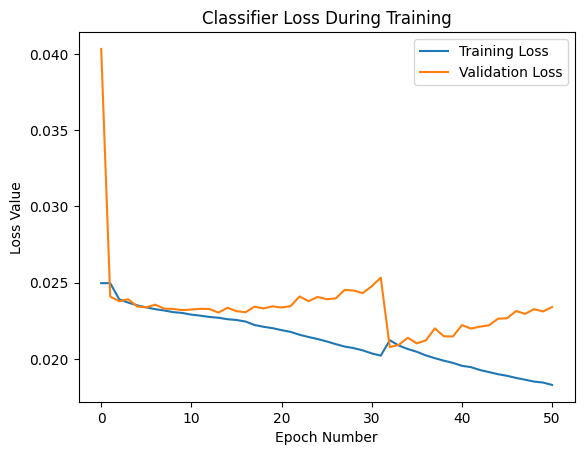

In [36]:
epoch_count_arr = np.arange(0, 51)

plt.plot(epoch_count_arr, losses, label = "Training Loss")
plt.plot(epoch_count_arr, v_losses, label = "Validation Loss")
plt.legend()
plt.xlabel ('Epoch Number')
plt.ylabel ('Loss Value')
plt.title("Classifier Loss During Training")
plt.show()

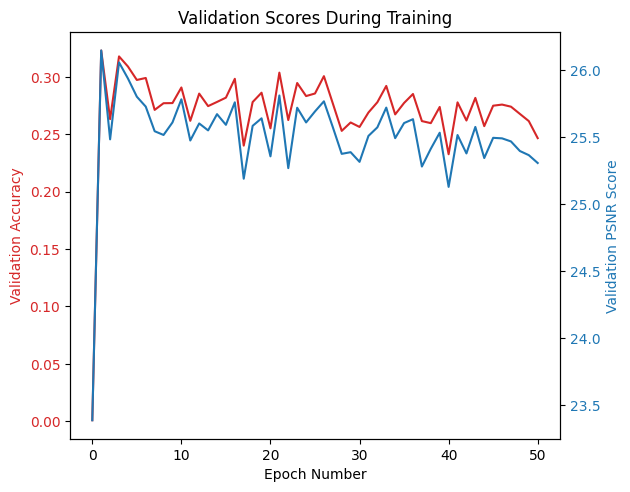

In [37]:
# Source: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html
epoch_count_arr = np.arange(0, 51)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch Number')
ax1.set_ylabel('Validation Accuracy', color='tab:red')
ax1.plot(epoch_count_arr, v_accs, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()

ax2.set_ylabel('Validation PSNR Score', color='tab:blue')
ax2.plot(epoch_count_arr, v_psnrs, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.title("Validation Scores During Training")
plt.show()

In [ ]:
# Save the current model state if desired
torch.save(model.state_dict(), "model_weights.pth")

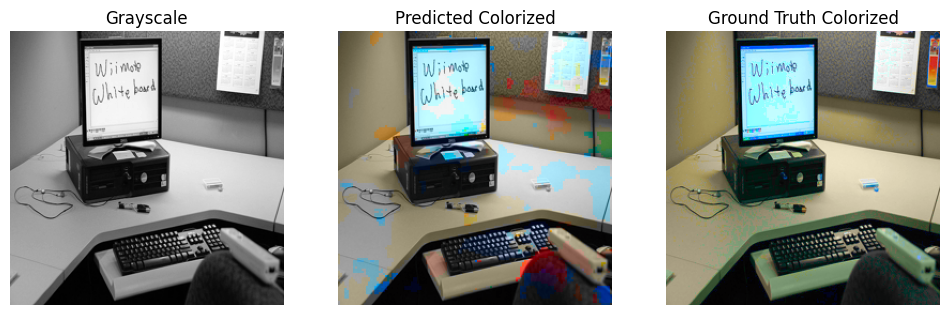

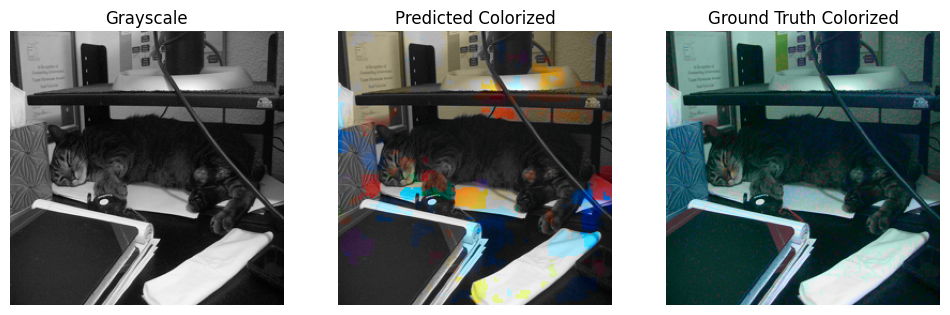

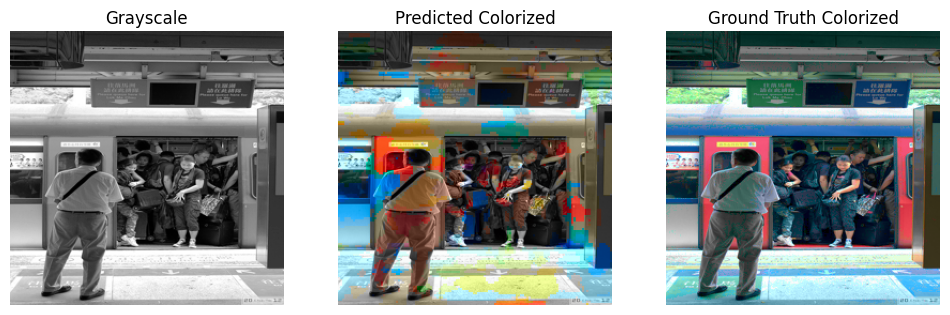

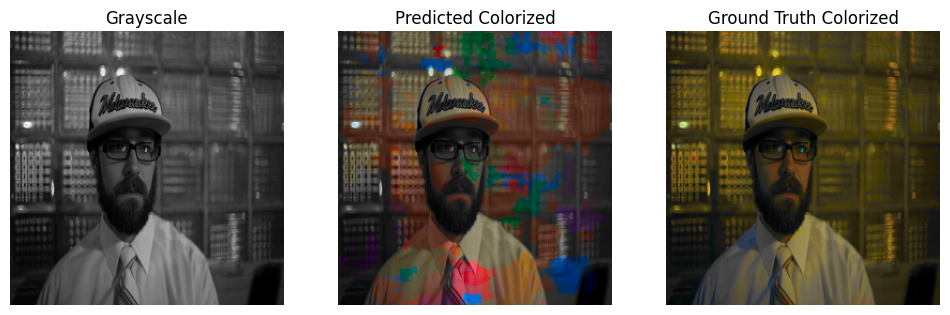

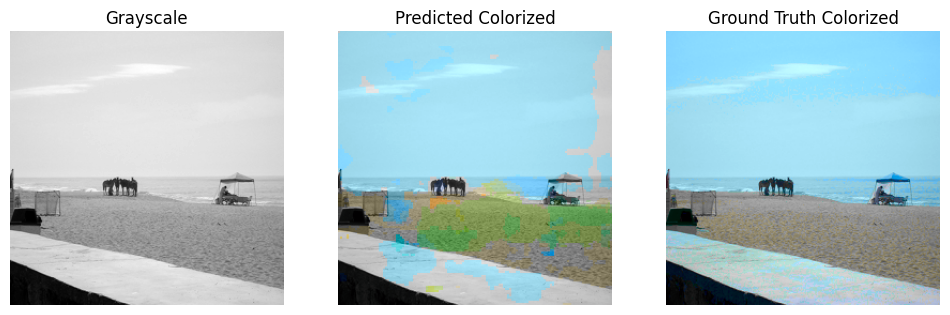

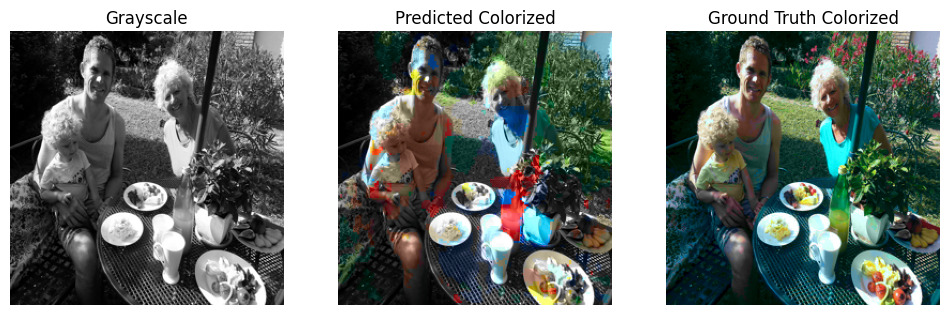

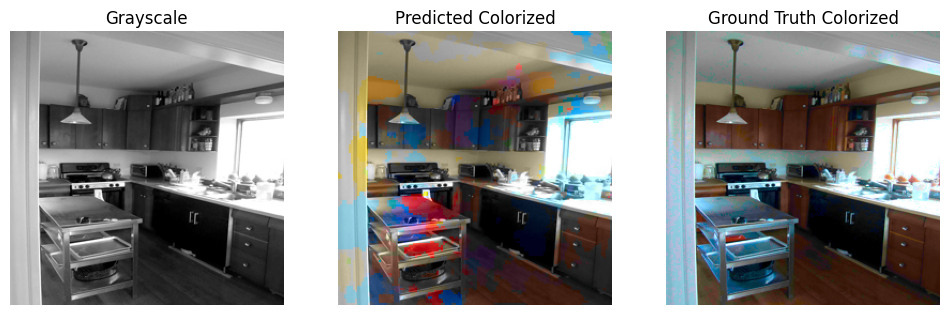

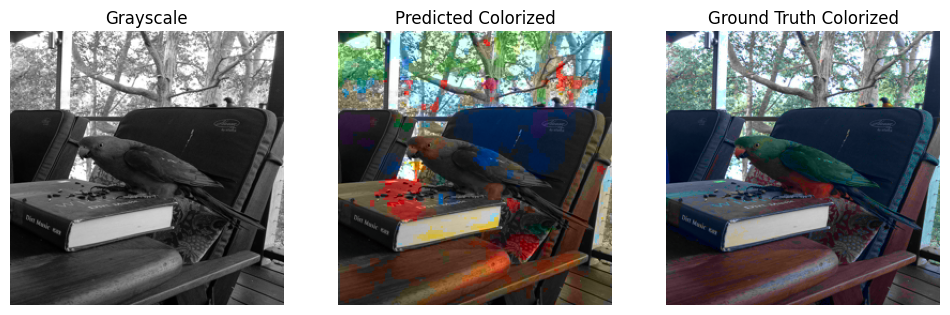

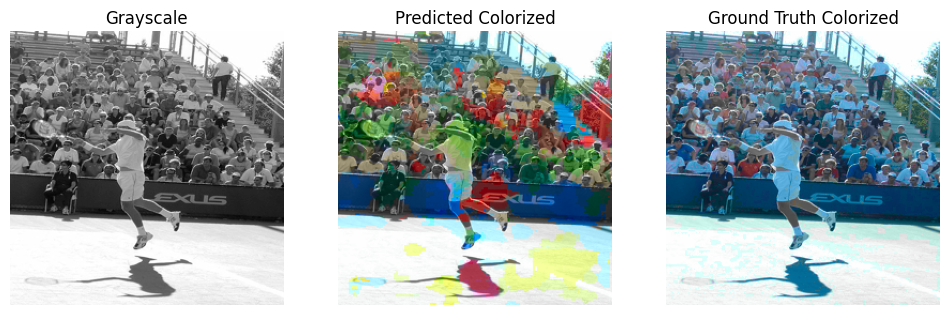

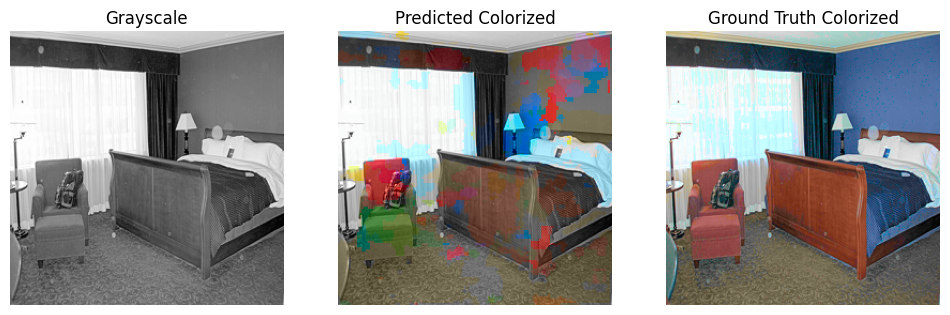

In [53]:
# Print model output
for i in range(10):
  see_output(model, val_names[100+i]) # Modify the constant to see different images

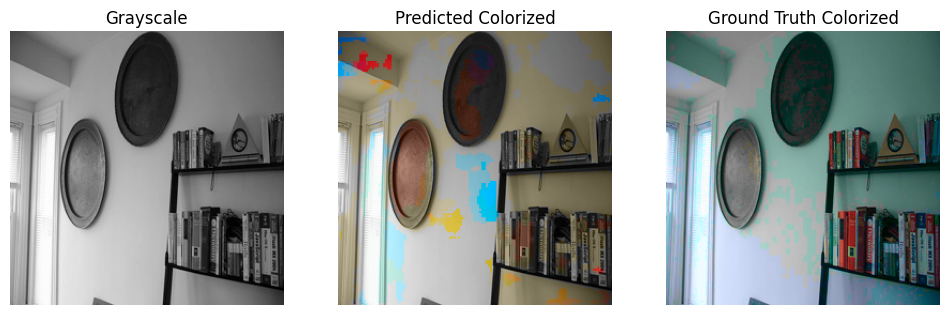

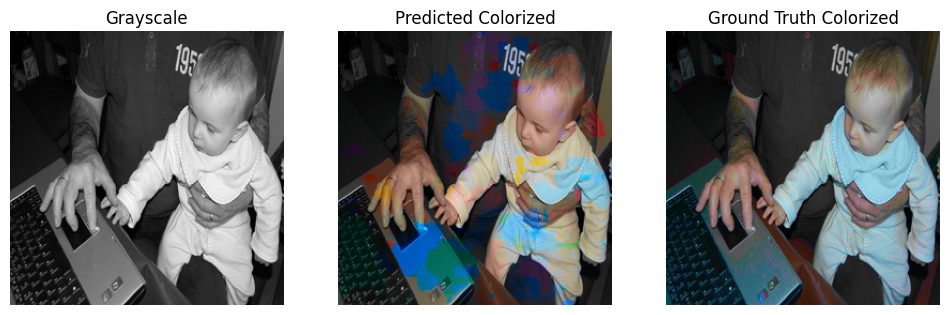

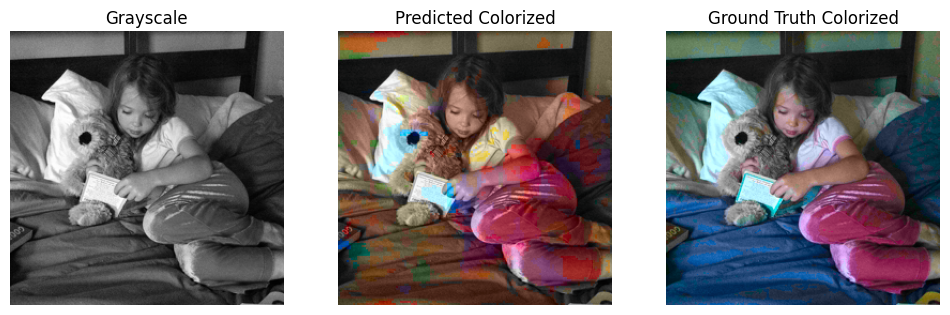

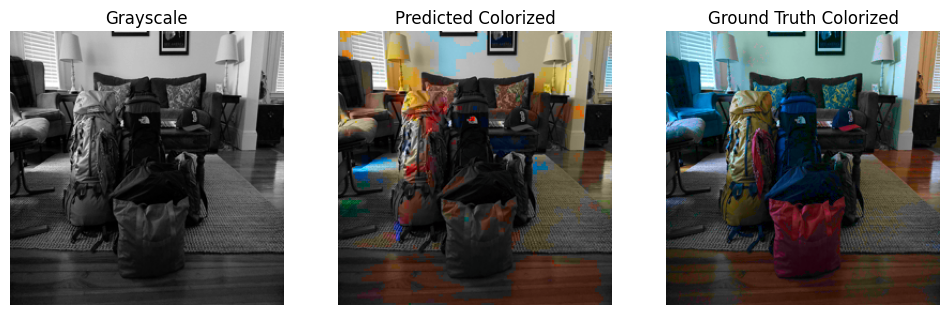

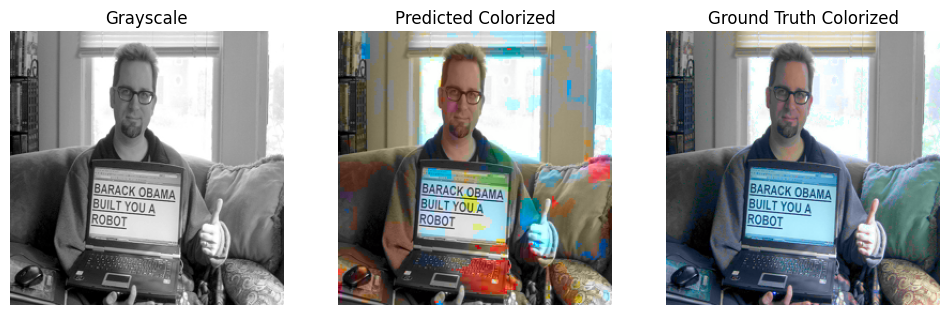

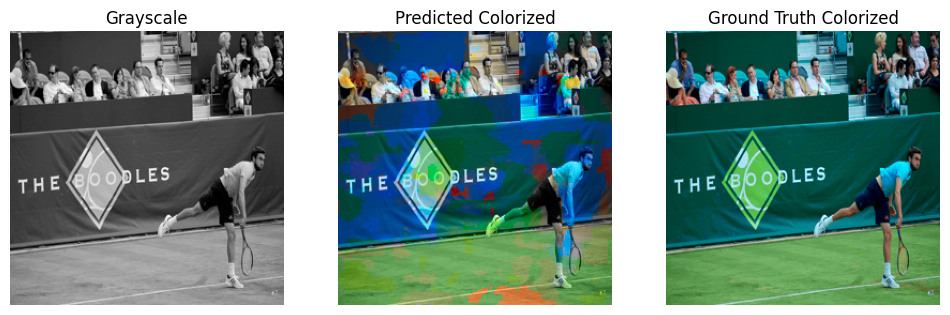

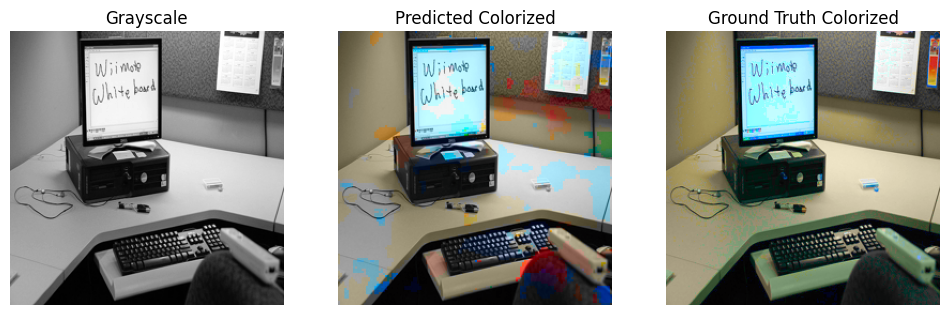

In [54]:
# Some of the better outputs, cherry-picked
see_output(model, val_names[10])
see_output(model, val_names[22])
see_output(model, val_names[30])
see_output(model, val_names[49])
see_output(model, val_names[70])
see_output(model, val_names[72])
see_output(model, val_names[100])